In [1]:
import pandas as pd
import os
import shutil
import numpy as np

***

# Data preparation

In [2]:
data = pd.read_csv('mpii_human_pose.csv')
data.head()

,ID,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,...,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,1,015601864.jpg,620,394,616,269,573,185,647,188,...,167,692,185,693,240,688,313,3.021046,curling,sports
1,2,015599452.jpg,-1,-1,-1,-1,806,543,720,593,...,281,719,299,711,516,545,466,5.641276,curling,sports
2,3,005808361.jpg,804,711,816,510,908,438,1040,454,...,253,1067,253,1167,353,1142,478,4.718488,curling,sports
3,4,086617615.jpg,301,461,305,375,201,340,294,342,...,261,314,264,327,320,362,346,2.681349,curling,sports
4,5,060111501.jpg,980,322,896,318,865,248,943,226,...,147,923,123,995,163,961,223,3.806403,curling,sports


In [3]:
KEYPOINTS_COLUMN_NAMES = [
    'r ankle_X',
    'r ankle_Y',
    'r knee_X',
    'r knee_Y',
    'r hip_X',
    'r hip_Y',
    'l hip_X',
    'l hip_Y',
    'l knee_X',
    'l knee_Y',
    'l ankle_X',
    'l ankle_Y',
    'pelvis_X',
    'pelvis_Y',
    'thorax_X',
    'thorax_Y',
    'upper neck_X',
    'upper neck_Y',
    'head top_X',
    'head top_Y',
    'r wrist_X',
    'r wrist_Y',
    'r elbow_X',
    'r elbow_Y',
    'r shoulder_X',
    'r shoulder_Y',
    'l shoulder_X',
    'l shoulder_Y',
    'l elbow_X',
    'l elbow_Y',
    'l wrist_X',
    'l wrist_Y',
]

CONNECTIONS = {

}

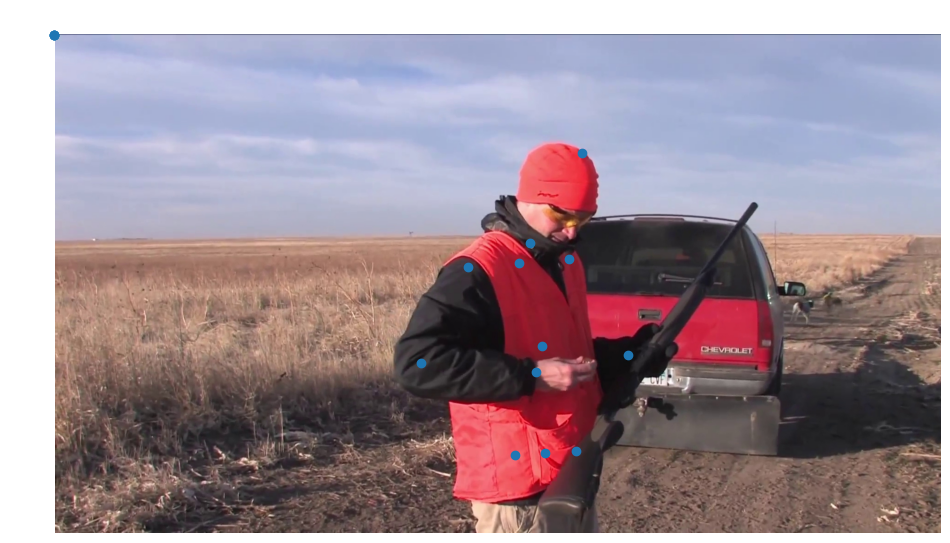

In [4]:
import matplotlib.pyplot as plt 
from PIL import Image

image_name = '045313633.jpg'

sample_img = Image.open(os.path.join('./images', image_name))
sample_keypoints = data[data['NAME'] == image_name]

Xs = [sample_keypoints[col].values[0] for col in KEYPOINTS_COLUMN_NAMES if col.endswith('_X')]
Ys = [sample_keypoints[col].values[0] for col in KEYPOINTS_COLUMN_NAMES if col.endswith('_Y')]

plt.figure(figsize=(12, 7))

plt.imshow(sample_img)
plt.scatter(Xs, Ys)
plt.axis('off')

plt.show()

In [5]:
# test dataset
test_data = pd.read_csv('var_12.csv', usecols=data.columns)
test_data.head()

,ID,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,...,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,8680,077910419.jpg,77,436,88,326,42,234,13,230,...,93,73,89,73,163,113,214,1.979091,"operating snow blower, walking",winter activities
1,8681,072478930.jpg,160,444,191,363,175,265,125,267,...,127,189,107,187,184,233,240,2.088138,"operating snow blower, walking",winter activities
2,8682,005952620.jpg,181,451,194,359,169,259,152,259,...,129,152,127,151,199,192,254,1.724162,"operating snow blower, walking",winter activities
3,8683,058150831.jpg,-1,-1,-1,-1,260,173,217,171,...,61,214,60,233,120,264,168,1.185755,"operating snow blower, walking",winter activities
4,8684,012175200.jpg,-1,-1,452,623,828,710,-1,-1,...,307,849,290,940,621,663,524,7.882603,sitting quietly,inactivity quiet/light


In [6]:
# remove test_data from data and shuffle
data = pd.concat([data, test_data]).drop_duplicates(keep=False).sample(frac=1)

# train/validate разбиение
train_val_partition = 0.80
train_val_n = int(train_val_partition * len(data))

train_data = data.iloc[:train_val_n]
val_data = data.iloc[train_val_n:]

In [7]:
# Выбираем классы

idx_class = {i: cat for i, cat in enumerate(sorted(data['Category'].unique()))}
class_idx = {cat: i for i, cat in idx_class.items()}

idx_class

{0: '[]',
 1: 'bicycling',
 2: 'conditioning exercise',
 3: 'dancing',
 4: 'fishing and hunting',
 5: 'home activities',
 6: 'home repair',
 7: 'inactivity quiet/light',
 8: 'lawn and garden',
 9: 'miscellaneous',
 10: 'music playing',
 11: 'occupation',
 12: 'religious activities',
 13: 'running',
 14: 'self care',
 15: 'sports',
 16: 'transportation',
 17: 'volunteer activities',
 18: 'walking',
 19: 'water activities',
 20: 'winter activities'}

In [8]:
def write_label_date(row, dir, image_name, bbox_offset=50):
    img = Image.open(os.path.join('./images', f'{image_name}.jpg'))
    width, height = img.width, img.height

    point_names = list(set([col.split('_')[0]
                       for col in KEYPOINTS_COLUMN_NAMES]))
    Xs = [float(row[col + '_X']) for col in point_names if row[col + '_X'] > 0]
    Ys = [float(row[col + '_Y']) for col in point_names if row[col + '_Y'] > 0]
    min_x, max_x = max(min(Xs) -
                       bbox_offset, 0), min(max(Xs) +
                                            bbox_offset, width)
    min_y, max_y = max(min(Ys) -
                       bbox_offset, 0), min(max(Ys) +
                                            bbox_offset, height)

    with open(os.path.join(dir, image_name + '.txt'), 'w') as label_file:
        str_out = ""
        str_out += str(class_idx[row['Category']]) + " "
        str_out += str((min_x + (max_x - min_x) / 2) / width) + " "
        str_out += str((min_y + (max_y - min_y) / 2) / height) + " "
        str_out += str((max_x - min_x) / width) + " "
        str_out += str((max_y - min_y) / height) + " "

        for point in point_names:
            x = float(row[point + '_X'])
            y = float(row[point + '_Y'])

            if x < 0 or y < 0:
                str_out += "0.0 0.0 0 "
            else:
                str_out += str(x / width) + " " + str(y / height) + " 2 "

        label_file.write(str_out)

In [9]:
# Конвертируем датасет в формат yolov

from tqdm import tqdm

all_data = {'train': train_data, 'valid': val_data, 'test': test_data}

yolov_ds_path = './yolov_dataset'

os.makedirs(yolov_ds_path, exist_ok=True)
for part in all_data:
    os.makedirs(os.path.join(yolov_ds_path, part, 'images'), exist_ok=True)
    os.makedirs(os.path.join(yolov_ds_path, part, 'labels'), exist_ok=True)

    for _, row in tqdm(all_data[part].iterrows()):
        image_name = row['NAME'].split('.')[0]
        img = Image.open(os.path.join('./images', f'{image_name}.jpg'))

        shutil.copy(
            f'./images/{image_name}.jpg',
            f'{yolov_ds_path}/{part}/images/{image_name}.jpg'
        )

        write_label_date(row, f'{yolov_ds_path}/{part}/labels/', image_name)

13280it [00:05, 2246.72it/s]
3321it [00:03, 1101.95it/s]
789it [00:01, 671.56it/s] 


In [10]:
print("Размер тренировочной выборки: ", len(train_data))
print("Размер валидационной выборки: ", len(val_data))
print("Размер тестовой выборки: ", len(test_data))
print()
print("Количество ключевых точек: ", int(len(KEYPOINTS_COLUMN_NAMES) / 2))
print("Количество состояний для предсказания: ", len(class_idx.keys()))

Размер тренировочной выборки:  13280
Размер валидационной выборки:  3321
Размер тестовой выборки:  789

Количество ключевых точек:  16
Количество состояний для предсказания:  21


***

## Модель

In [ ]:
%tensorboard

In [1]:
from ultralytics import YOLO

model = YOLO('yolov8s-pose.pt')

In [2]:
results = model.train(data='./yolov_dataset/data.yaml', epochs=50, imgsz=640, batch=16)

Ultralytics YOLOv8.2.18 🚀 Python-3.9.19 torch-2.3.0 CUDA:0 (NVIDIA GeForce RTX 3070, 7952MiB)
engine/trainer: task=pose, mode=train, model=yolov8s-pose.pt, data=./yolov_dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

/home/student1/project/ml_env/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608883701/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
train: Scanning /home/student1/project/yolov_dataset/train/labels... 13276 images, 0 backgrounds, 37 corrupt: 100%|██████████| 13276/13276 [00:17<00:00, 744.53it/s]

train: WARNING ⚠️ /home/student1/project/yolov_dataset/train/images/000312165.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0042]
train: WARNING ⚠️ /home/student1/project/yolov_dataset/train/images/001496120.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0042]
train: WARNING ⚠️ /home/student1/project/yolov_dataset/train/images/005166872.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0125      1.0069]
train: WARNING ⚠️ /home/student1/project/yolov_dataset/train/images/005226867.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0417]
train: WARNING ⚠️ /home/student1/project/yolov_dataset/train/images/006942384.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.013]
train: WARNING ⚠️ /home/student1/project/yolov_dataset/train/images/011121658.jpg: ignoring corrupt image/label: non-normalized or ou

train: New cache created: /home/student1/project/yolov_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/student1/project/yolov_dataset/valid/labels... 3321 images, 0 backgrounds, 6 corrupt: 100%|██████████| 3321/3321 [00:02<00:00, 1113.63it/s]

val: WARNING ⚠️ /home/student1/project/yolov_dataset/valid/images/004770834.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0065]
val: WARNING ⚠️ /home/student1/project/yolov_dataset/valid/images/035075321.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0042]
val: WARNING ⚠️ /home/student1/project/yolov_dataset/valid/images/035164987.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0093]
val: WARNING ⚠️ /home/student1/project/yolov_dataset/valid/images/039940030.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0847      1.0986]
val: WARNING ⚠️ /home/student1/project/yolov_dataset/valid/images/089419087.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0009]
val: WARNING ⚠️ /home/student1/project/yolov_dataset/valid/images/089761401.jpg: ignoring corrupt image/label: non-normalized or out of bounds 

Plotting labels to runs/pose/train12/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/pose/train12
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/828 [00:00<?, ?it/s]/home/student1/project/ml_env/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608883701/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
       1/50      4.29G      1.222      8.137     0.6593      3.112      1.341         11        640: 100%|██████████| 828/828 [02:03<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00,  9.69it/s]


                   all       3315       3315      0.415      0.297      0.187      0.129      0.248      0.111     0.0275     0.0039

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.35G      1.175      6.016     0.5942      2.446      1.273         17        640: 100%|██████████| 828/828 [02:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.04it/s]


                   all       3315       3315      0.449      0.359      0.214      0.129      0.372      0.237     0.0875     0.0149

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.33G      1.306      6.099     0.5634      2.346      1.346         20        640: 100%|██████████| 828/828 [02:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.02it/s]


                   all       3315       3315      0.373      0.281      0.158      0.083      0.294       0.13     0.0448    0.00729

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.21G      1.414      6.391     0.4981      2.373      1.413         14        640: 100%|██████████| 828/828 [01:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.10it/s]


                   all       3315       3315      0.456      0.294      0.187     0.0974      0.381      0.164     0.0606       0.01

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       5/50       4.2G      1.381      6.167     0.4386      2.259      1.385         16        640: 100%|██████████| 828/828 [01:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.11it/s]


                   all       3315       3315      0.488      0.309      0.235      0.137      0.398      0.159     0.0811     0.0115

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       6/50       4.2G      1.336      5.976     0.4095      2.157      1.356         17        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.10it/s]

                   all       3315       3315      0.416      0.355      0.269      0.173       0.32      0.205      0.096     0.0148



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.18G      1.305      5.836     0.3915      2.085      1.336         13        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.11it/s]

                   all       3315       3315      0.469      0.324       0.28      0.167      0.374        0.2      0.115     0.0196



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.18G       1.28      5.736     0.3791      2.044      1.318         14        640: 100%|██████████| 828/828 [01:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.08it/s]

                   all       3315       3315      0.402      0.382      0.302      0.203        0.3      0.236      0.131     0.0212



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.19G      1.261      5.613     0.3724      1.989        1.3         16        640: 100%|██████████| 828/828 [01:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.13it/s]

                   all       3315       3315      0.604      0.319      0.311      0.199      0.495      0.203      0.134     0.0211



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.19G       1.24      5.559     0.3662       1.94       1.29         16        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.15it/s]

                   all       3315       3315      0.501      0.372      0.337      0.226      0.416      0.248      0.175     0.0312



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.18G      1.224      5.491      0.362      1.901      1.281         15        640: 100%|██████████| 828/828 [01:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.17it/s]

                   all       3315       3315      0.463      0.428      0.361      0.244      0.342      0.277      0.179     0.0321



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.18G      1.203       5.43     0.3593      1.863       1.27         19        640: 100%|██████████| 828/828 [01:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.19it/s]

                   all       3315       3315      0.582      0.368      0.375      0.258        0.5      0.252      0.212     0.0388



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.18G      1.189      5.403     0.3542      1.824      1.257         21        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.18it/s]

                   all       3315       3315      0.571      0.406      0.391      0.275      0.445      0.301      0.218     0.0402



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.18G       1.17      5.331     0.3532      1.796      1.252         14        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.18it/s]

                   all       3315       3315      0.509      0.388      0.382      0.245      0.381      0.301      0.203     0.0349



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.17G       1.15      5.289     0.3519      1.774      1.235         16        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.12it/s]

                   all       3315       3315      0.555      0.417      0.411      0.293      0.462       0.32      0.259     0.0491



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.17G      1.138      5.187      0.348      1.737      1.231         14        640: 100%|██████████| 828/828 [01:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.19it/s]

                   all       3315       3315      0.569      0.401      0.422      0.302       0.44      0.292      0.246     0.0471



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.18G       1.12      5.168      0.348      1.704      1.227         19        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.22it/s]

                   all       3315       3315      0.483      0.482      0.433      0.312      0.385       0.35      0.256      0.049



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.17G      1.116      5.138     0.3447      1.673      1.218         19        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.20it/s]

                   all       3315       3315      0.551      0.437      0.439      0.312      0.445      0.333      0.266     0.0498



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.18G      1.092      5.105     0.3432      1.651       1.21         17        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.21it/s]

                   all       3315       3315      0.547      0.452       0.44      0.311      0.435       0.36      0.281     0.0532



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.18G      1.084      5.061     0.3422      1.635      1.203         21        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.23it/s]

                   all       3315       3315      0.582      0.447      0.462      0.335      0.515      0.339      0.291     0.0557



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.17G      1.076      5.046     0.3394      1.604      1.198         14        640: 100%|██████████| 828/828 [01:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.12it/s]

                   all       3315       3315      0.572      0.463      0.466      0.341      0.496      0.353      0.311     0.0613



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.17G      1.062      4.981     0.3357      1.581       1.19         17        640: 100%|██████████| 828/828 [01:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.20it/s]

                   all       3315       3315      0.562      0.463      0.469      0.337      0.517      0.342      0.308     0.0594



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.17G      1.048      4.951     0.3357      1.549      1.185         20        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.22it/s]

                   all       3315       3315      0.662      0.451      0.497      0.365      0.574       0.36      0.339     0.0654



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.17G      1.037      4.934      0.336      1.536      1.176         24        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.20it/s]

                   all       3315       3315      0.533       0.51      0.493      0.367      0.439      0.404      0.341     0.0675



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.17G      1.032      4.908     0.3341      1.515      1.177         16        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.23it/s]

                   all       3315       3315      0.612      0.469      0.498      0.369      0.538      0.365      0.342     0.0661



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.17G      1.021      4.883     0.3314      1.489      1.166         11        640: 100%|██████████| 828/828 [01:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.24it/s]

                   all       3315       3315      0.591       0.47       0.51      0.379      0.509       0.37      0.353     0.0711



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.17G      1.013      4.853     0.3316      1.464      1.169         14        640: 100%|██████████| 828/828 [01:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.24it/s]

                   all       3315       3315      0.584      0.482      0.507      0.379      0.497       0.39      0.357     0.0705



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.17G     0.9981      4.805     0.3303      1.449      1.155         14        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.15it/s]

                   all       3315       3315       0.58      0.494      0.519       0.39      0.497       0.41      0.377     0.0758



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.17G     0.9857       4.78     0.3277      1.423      1.152         15        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.20it/s]

                   all       3315       3315      0.603      0.503      0.536      0.406       0.52      0.403      0.384     0.0798



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.17G     0.9799      4.763     0.3268       1.41      1.151         14        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.24it/s]

                   all       3315       3315       0.58      0.491      0.545      0.411      0.509      0.392      0.395     0.0802



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.17G     0.9708      4.715     0.3265      1.369      1.143         18        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.22it/s]

                   all       3315       3315      0.532      0.525      0.536      0.408      0.469      0.434      0.406     0.0853



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.17G     0.9594      4.697     0.3254      1.365      1.139         11        640: 100%|██████████| 828/828 [01:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.22it/s]

                   all       3315       3315      0.628      0.492      0.545      0.413      0.548       0.39      0.392     0.0839



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.17G     0.9509      4.671     0.3235       1.34      1.138         20        640: 100%|██████████| 828/828 [01:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.22it/s]

                   all       3315       3315      0.597      0.502      0.552      0.417      0.509       0.42       0.41     0.0854



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.17G     0.9413      4.655     0.3228      1.318      1.128         14        640: 100%|██████████| 828/828 [01:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.23it/s]

                   all       3315       3315      0.566      0.529      0.559      0.426      0.485      0.441      0.419     0.0875



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.18G     0.9307      4.625     0.3232      1.289      1.128         18        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.17it/s]

                   all       3315       3315      0.569      0.541      0.564       0.43      0.528      0.425      0.428     0.0908



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.17G     0.9208      4.591     0.3199      1.274      1.121         21        640: 100%|██████████| 828/828 [01:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.23it/s]

                   all       3315       3315      0.591      0.537      0.574      0.437      0.499      0.448      0.425     0.0882



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.17G     0.9129      4.597     0.3235      1.248       1.12         15        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.25it/s]

                   all       3315       3315      0.616      0.503      0.571      0.437      0.533      0.425      0.433     0.0947



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.17G     0.9093      4.569     0.3183      1.231      1.118         14        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.25it/s]

                   all       3315       3315      0.585      0.536      0.571      0.435      0.511       0.45      0.431     0.0935



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.16G     0.8914       4.53     0.3165      1.219      1.106         13        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.23it/s]

                   all       3315       3315      0.589      0.524      0.578      0.442      0.537      0.417      0.435     0.0949



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.17G     0.8786      4.508      0.321      1.193      1.105         20        640: 100%|██████████| 828/828 [01:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.21it/s]

                   all       3315       3315        0.6      0.533      0.579      0.446       0.52       0.45      0.438     0.0944


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.17G      0.767      4.371     0.1735     0.8962      1.057          7        640: 100%|██████████| 828/828 [02:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.26it/s]

                   all       3315       3315      0.674      0.524       0.59      0.455      0.587      0.443      0.451     0.0969



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.18G     0.7469      4.337     0.1713     0.8485      1.047          7        640: 100%|██████████| 828/828 [01:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.26it/s]

                   all       3315       3315      0.646      0.539      0.602      0.465      0.557      0.463      0.466      0.104



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.17G     0.7258      4.308     0.1694     0.7982      1.037          7        640: 100%|██████████| 828/828 [01:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.27it/s]

                   all       3315       3315      0.611      0.573        0.6      0.464       0.53      0.487       0.46      0.103



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.17G     0.7122      4.289     0.1696     0.7784      1.024          7        640: 100%|██████████| 828/828 [01:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.25it/s]

                   all       3315       3315      0.661      0.545      0.607      0.472      0.587      0.463      0.472      0.102



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.17G     0.6951      4.254     0.1669     0.7363      1.017          7        640: 100%|██████████| 828/828 [01:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.27it/s]

                   all       3315       3315      0.638      0.565      0.607      0.469      0.567      0.476      0.476      0.105



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.17G     0.6799      4.234      0.168     0.7128      1.005          7        640: 100%|██████████| 828/828 [01:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.26it/s]

                   all       3315       3315      0.661      0.537      0.604      0.468      0.606      0.451      0.475      0.105



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.17G     0.6637      4.223      0.165     0.6896     0.9996          7        640: 100%|██████████| 828/828 [01:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.25it/s]

                   all       3315       3315      0.682      0.516      0.606      0.471      0.596      0.444      0.476      0.108



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.17G     0.6545      4.206     0.1652      0.664      0.995          7        640: 100%|██████████| 828/828 [01:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.26it/s]

                   all       3315       3315      0.632      0.556      0.603      0.468      0.554      0.475      0.474      0.109



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.16G     0.6431       4.18     0.1641     0.6393     0.9853          7        640: 100%|██████████| 828/828 [01:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.23it/s]

                   all       3315       3315       0.66      0.531      0.606       0.47      0.588      0.452      0.472      0.111



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.17G     0.6295      4.167     0.1653     0.6236     0.9815          7        640: 100%|██████████| 828/828 [01:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00, 10.28it/s]

                   all       3315       3315      0.675      0.526      0.606      0.471       0.61      0.444      0.476      0.113



50 epochs completed in 1.816 hours.
Optimizer stripped from runs/pose/train12/weights/last.pt, 23.5MB
Optimizer stripped from runs/pose/train12/weights/best.pt, 23.5MB

Validating runs/pose/train12/weights/best.pt...
Ultralytics YOLOv8.2.18 🚀 Python-3.9.19 torch-2.3.0 CUDA:0 (NVIDIA GeForce RTX 3070, 7952MiB)
YOLOv8s-pose summary (fused): 187 layers, 11590335 parameters, 0 gradients, 30.1 GFLOPs


/home/student1/project/ml_env/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608883701/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:10<00:00,  9.95it/s]


                   all       3315       3315      0.679      0.524      0.607      0.472      0.611      0.444      0.476      0.114
                    []       3315          7          0          0      0.022     0.0199          0          0     0.0186    0.00517
             bicycling       3315         66      0.825      0.727      0.825      0.599      0.724      0.621      0.638      0.111
 conditioning exercise       3315        306      0.787      0.761      0.832      0.689      0.668      0.625      0.636      0.135
               dancing       3315        137      0.597      0.533      0.637      0.492       0.55       0.46      0.491      0.102
   fishing and hunting       3315        121      0.811      0.661      0.815      0.625      0.639      0.512      0.503     0.0942
       home activities       3315        281      0.692      0.585      0.704      0.551      0.638       0.52      0.565      0.152
           home repair       3315        177      0.607      0.663   

In [4]:
metrics = model.val(split="test", plots=True)

Ultralytics YOLOv8.2.18 🚀 Python-3.9.19 torch-2.3.0 CUDA:0 (NVIDIA GeForce RTX 3070, 7952MiB)


val: Scanning /home/student1/project/yolov_dataset/test/labels... 789 images, 0 backgrounds, 3 corrupt: 100%|██████████| 789/789 [00:01<00:00, 749.71it/s]

val: WARNING ⚠️ /home/student1/project/yolov_dataset/test/images/011160320.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0065]
val: WARNING ⚠️ /home/student1/project/yolov_dataset/test/images/052008994.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0047]
val: WARNING ⚠️ /home/student1/project/yolov_dataset/test/images/059248640.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0833      1.0667]


val: New cache created: /home/student1/project/yolov_dataset/test/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:04<00:00, 11.28it/s]


                   all        786        786      0.418      0.347      0.361      0.284      0.377      0.304      0.294     0.0713
             bicycling        786        133      0.657      0.737      0.763      0.605      0.592      0.662      0.654      0.124
 conditioning exercise        786         76      0.707      0.526      0.689       0.57       0.62      0.461      0.585      0.129
               dancing        786         22      0.101      0.136      0.177      0.136      0.102      0.136      0.152     0.0283
   fishing and hunting        786         39      0.857      0.769      0.877      0.677      0.776      0.692      0.748      0.255
       home activities        786         38      0.152      0.342      0.169      0.132      0.117      0.263     0.0756     0.0202
           home repair        786         47      0.343      0.404      0.399       0.31      0.325      0.383      0.369      0.105
inactivity quiet/light        786         18          0          0   

# Test metrics
![alt text](runs/pose/train123/BoxF1_curve.png)
![alt text](runs/pose/train123/BoxP_curve.png)
![alt text](runs/pose/train123/BoxPR_curve.png)
![alt text](runs/pose/train123/BoxR_curve.png)
![alt text](runs/pose/train123/confusion_matrix_normalized.png)
![alt text](runs/pose/train123/confusion_matrix.png)
![alt text](runs/pose/train123/PoseF1_curve.png)
![alt text](runs/pose/train123/PoseP_curve.png)
![alt text](runs/pose/train123/PosePR_curve.png)
![alt text](runs/pose/train123/PoseR_curve.png)
***
# Batch0
## Labels
![alt text](runs/pose/train123/val_batch0_labels.jpg)
## Preds
![alt text](runs/pose/train123/val_batch0_pred.jpg)
***
# Batch1
## Labels
![alt text](runs/pose/train123/val_batch1_labels.jpg)
## Preds
![alt text](runs/pose/train123/val_batch1_pred.jpg)
***
# Batch2
## Labels
![alt text](runs/pose/train123/val_batch2_labels.jpg)
## Preds
![alt text](runs/pose/train123/val_batch2_pred.jpg)